# Network Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

Create user user_id list from preprocessed data

In [2]:
data = pd.read_csv('../output/preprocessed.csv')

user_dict = {}

# Function to add a user ID to a username
def add_user_id(username, user_id):
    if username in user_dict:
        user_dict[username].append(user_id)
    else:
        user_dict[username] = [user_id]

for index, row in data.iterrows():
    add_user_id(row['user'], row['user_id'])

{k: user_dict[k] for k in list(user_dict)[:5]}

{'danielwoodard': [1077866112],
 'nelsonjacqueline': [1089670430],
 'ihooper': [1007478642, 1007478642],
 'wrightnicholas': [1039258480],
 'michael51': [1021455936, 1096712805, 1022492390]}

In [3]:
# Create a new column 'user' in data by mapping user_id to user using user_id_dict
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
data.head()

timestamp                                               text     text_id  \
0  00:00:00  run business mean juggle countless administrat...  2018569761   
1  00:00:00  liz truss walk linger shadow predecessor charl...  2092717718   
2  00:00:00  uk brace war government building london raise ...  2059143248   
3  00:00:00  marry second cousin remove taboo think genetic...  2008209828   
4  00:00:00  truly disgraceful indian national congress sto...  2001239278   

               user     user_id                                hashtags  \
0     danielwoodard  1077866112      ['#HRtech', '#businessmanagement']   
1  nelsonjacqueline  1089670430                           ['#politics']   
2           ihooper  1007478642  ['#Ukrainewashed', '#WarPreparedness']   
3    wrightnicholas  1039258480        ['#FamilyTree', '#GeneticFacts']   
4         michael51  1021455936                 ['#RationChorCongress']   

  mentions  frequency language  
0       []          1       en  
1       []          1       en  
2       []          1       en  
3       []          1       en  
4       []          1       en

In [4]:
# Create a new dataframe with non-empty mentions
data_mentions = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)][['user', 'mentions']]
print(f"Number of posts with mentions: {len(data_mentions)}")
data_mentions.head()

Number of posts with mentions: 35322


user                                           mentions
5      ihooper  ['gabrieltaylor', 'lori57', 'timothy62', 'andr...
7       mark89  ['mckenzieestrada', 'mckenzieestrada', 'shane2...
8     andrea21                               ['jonathanreynolds']
10  kimberly05                                 ['bethanycarroll']
11   kristen10                                         ['wdavis']

In [5]:
# Load the graph data
graph_data = pd.read_csv('../data/graph.csv')

# Flatten the list of user IDs from user_dict
user_ids = set([user_id for user_ids in user_dict.values() for user_id in user_ids])

# Check if any user ID in the graph.csv is not in the user relation list
missing_users_set = set(graph_data['source']).union(set(graph_data['target'])) - user_ids

# Convert the set of missing users to a DataFrame
missing_users = pd.DataFrame(list(missing_users_set), columns=['user_id'])

print(f"Number of missing users: {len(missing_users)}")

Number of missing users: 717


In [6]:
missing_users

user_id
0    1005090817
1    1046982657
2    8181721092
3    1048807428
4    1192646665
..          ...
712  1036550138
713  1049909243
714  1083273212
715  1027194877
716  1078618110

[717 rows x 1 columns]

In [7]:
initial_row_count = len(graph_data)

# Filter out rows where source or target is in missing_users_set
graph_data = graph_data[~graph_data['source'].isin(missing_users_set) & ~graph_data['target'].isin(missing_users_set)]

filtered_row_count = len(graph_data)

print(f"Number of removed rows: {initial_row_count - filtered_row_count}")

Number of removed rows: 2880


In [8]:
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
# Create a new dataframe by mapping both source and target columns
graph_data['source'] = graph_data['source'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data['target'] = graph_data['target'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data.head()

source         target  weight
0  eleonard     jamessimon       1
1  eleonard      brianna65       1
2  eleonard       yschmidt       1
5  eleonard       amanda97       1
6  eleonard  rosariohannah       1

In [9]:
len(graph_data)

92004

In [10]:
non_empty_mentions_count = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)].shape[0]
print(f"Number of rows in data with non-empty mentions: {non_empty_mentions_count}")

Number of rows in data with non-empty mentions: 35322


### Mentions (directed)

In [11]:
# Create a directed graph
mentioning_graph = nx.DiGraph()

# Add edges to the graph based on mentions
for index, row in data_mentions.iterrows():
    user = row['user']
    mentions = eval(row['mentions'])
    for mentioned_user in mentions:
        mentioning_graph.add_edge(user, mentioned_user)

# Print the number of nodes and edges in the mentioning graph
print(f"Number of nodes in the mentioning graph: {mentioning_graph.number_of_nodes()}")
print(f"Number of edges in the mentioning graph: {mentioning_graph.number_of_edges()}")

Number of nodes in the mentioning graph: 53179
Number of edges in the mentioning graph: 88158


In [12]:
# Compute in-degree centrality for the mentioning graph (directed)
in_degree_centrality_mentions = nx.in_degree_centrality(mentioning_graph)

### Followers (undirected)

In [13]:
# Create an undirected graph
following_graph = nx.Graph()

# Add edges to the graph
for index, row in graph_data.iterrows():
        following_graph.add_edge(row['source'], row['target'], weight=row['weight'])

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {following_graph.number_of_nodes()}")
print(f"Number of edges: {following_graph.number_of_edges()}")

Number of nodes: 37241
Number of edges: 91969


In [14]:
# Compute degree centrality for the following graph (undirected)
degree_centrality_following = nx.degree_centrality(following_graph)

In [15]:
# Create a MultiDiGraph
combined_graph = nx.MultiDiGraph()

# Add edges from the following graph
for u, v, data in following_graph.edges(data=True):
    combined_graph.add_edge(u, v, key='following', **data)

# Add edges from the mentioning graph
for u, v, data in mentioning_graph.edges(data=True):
    combined_graph.add_edge(u, v, key='mentioning', **data)

# Print the number of nodes and edges in the combined graph
print(f"Number of nodes in the combined graph: {combined_graph.number_of_nodes()}")
print(f"Number of edges in the combined graph: {combined_graph.number_of_edges()}")

Number of nodes in the combined graph: 64879
Number of edges in the combined graph: 180127


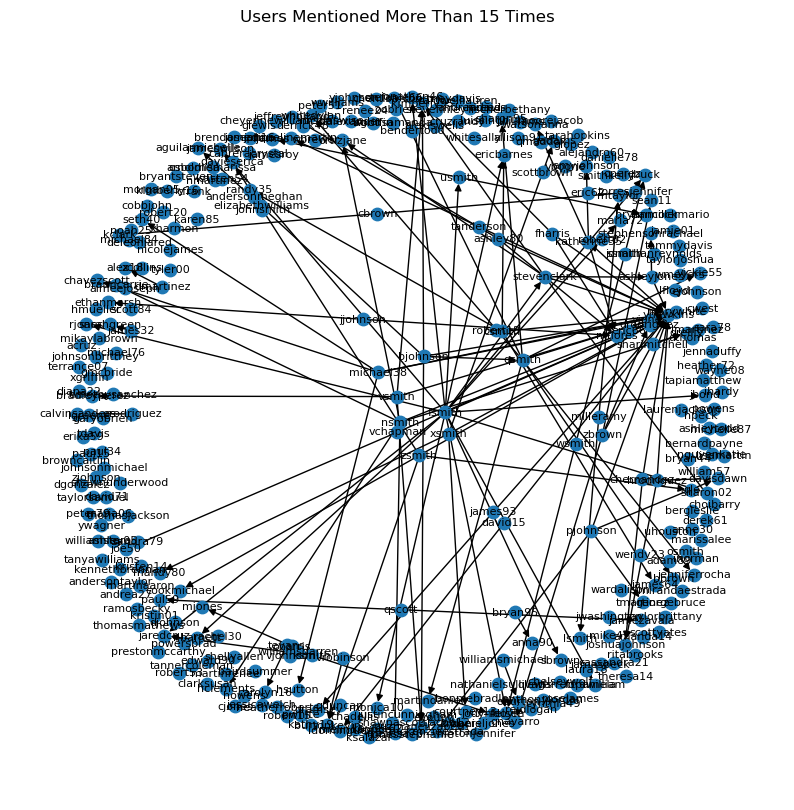

In [16]:
# Combine the scores to rank influential users
combined_centrality = {}
for user in set(degree_centrality_following.keys()).union(in_degree_centrality_mentions.keys()):
    combined_centrality[user] = degree_centrality_following.get(user, 0) + in_degree_centrality_mentions.get(user, 0)

# Sort users by combined centrality score in descending order
ranked_influential_users = sorted(combined_centrality.items(), key=lambda item: item[1], reverse=True)

# Generate positions for the nodes
pos = nx.fruchterman_reingold_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw_networkx(subgraph, pos, node_size=80, font_size=8, with_labels=True, font_color='black')
plt.title("Users Mentioned More Than 15 Times")
plt.axis("off")
plt.savefig('../figures/mentioned-more-than-15.png')
plt.show()

### Ego networks

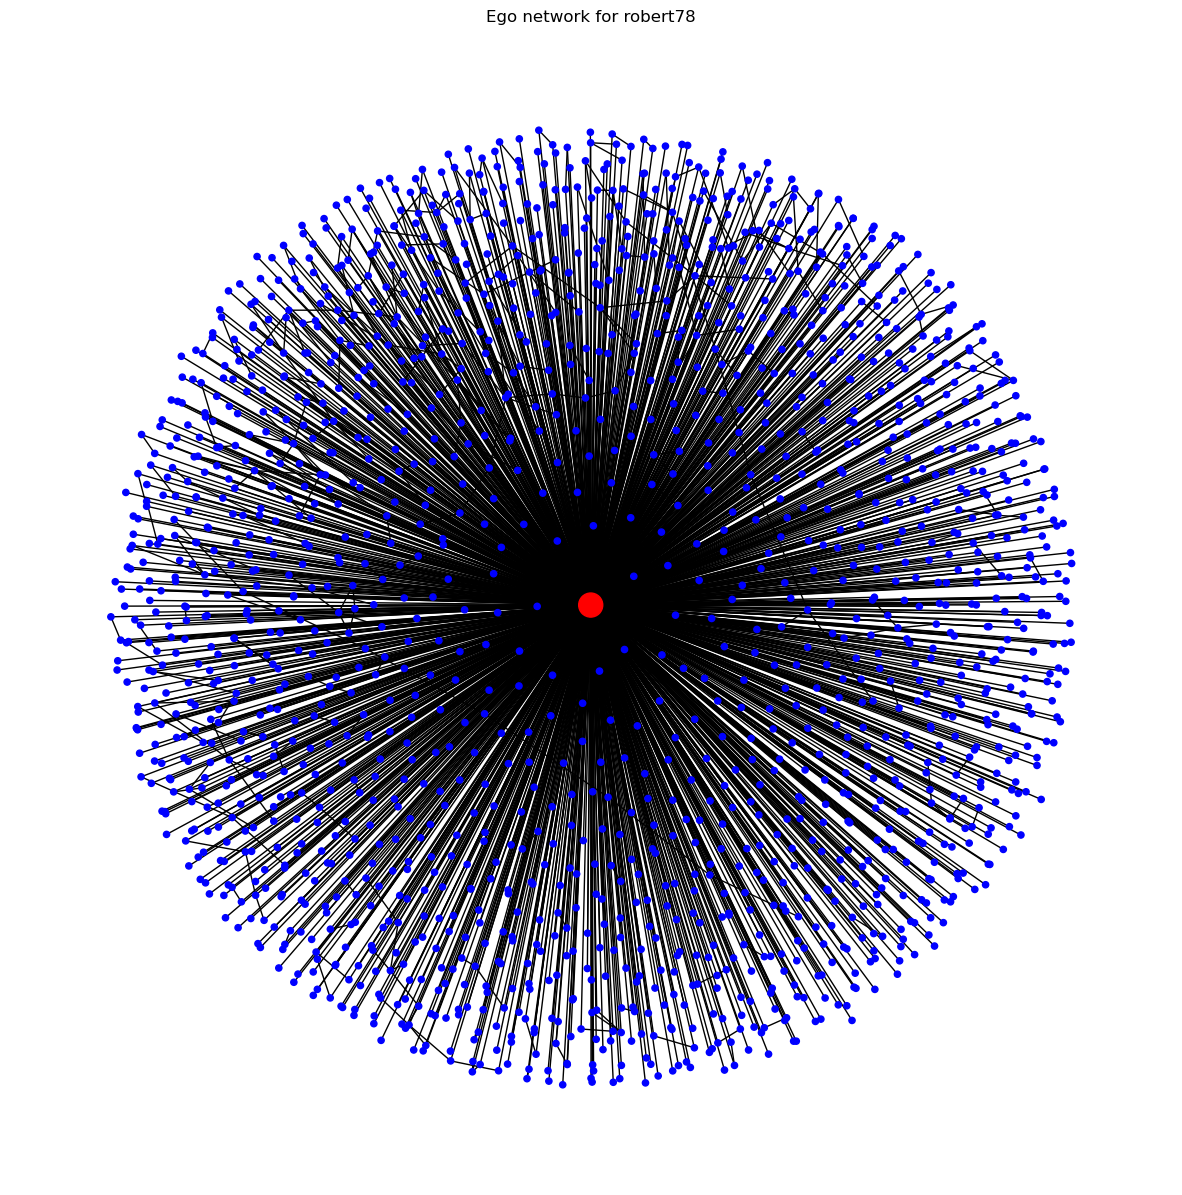

In [17]:
# Create an ego network for robert78
ego_network_robert78 = nx.ego_graph(following_graph, 'robert78')

# Draw the ego network with a larger figure size
layout = nx.spring_layout(ego_network_robert78)
plt.figure(figsize=(15, 15))

# Draw nodes with specific attributes for 'robert78'
node_colors = ['red' if node == 'robert78' else 'blue' for node in ego_network_robert78.nodes()]
node_sizes = [300 if node == 'robert78' else 20 for node in ego_network_robert78.nodes()]

nx.draw_networkx(ego_network_robert78, pos=layout, node_color=node_colors, node_size=node_sizes, font_size=8, with_labels=False)
plt.title("Ego network for robert78")
plt.axis("off")
plt.savefig('../figures/ego-network-robert78.png')
plt.show()

In [18]:
ego_network_robert78.number_of_nodes()

1745

## Playground

### Louvain

In [19]:
# Apply Louvain to the undirected following_graph
partition_following = nx.algorithms.community.louvain_communities(following_graph)

# Convert mentioning_graph to undirected for Louvain
mention_graph_undirected = mentioning_graph.to_undirected()
partition_mention = nx.algorithms.community.louvain_communities(mention_graph_undirected)

# Convert the partition lists to dictionaries for easier lookup
node_to_community_following = {}
for i, community in enumerate(partition_following):
	for node in community:
		node_to_community_following[node] = i

node_to_community_mention = {}
for i, community in enumerate(partition_mention):
	for node in community:
		node_to_community_mention[node] = i

In [20]:
# Count the number of members the following graph
counts = Counter({i: len(community) for i, community in enumerate(partition_following)})
sorted_communities = counts.most_common()

# Print the top following communities
for comm_id, size in sorted_communities[:15]:
    print(f"Community {comm_id} has {size} members")

Community 42 has 700 members
Community 82 has 697 members
Community 35 has 649 members
Community 51 has 645 members
Community 49 has 639 members
Community 10 has 635 members
Community 61 has 634 members
Community 38 has 607 members
Community 69 has 606 members
Community 41 has 562 members
Community 39 has 541 members
Community 77 has 538 members
Community 20 has 536 members
Community 33 has 525 members
Community 22 has 523 members


In [21]:
# Count the number of members the mentioning graph
counts = Counter({i: len(community) for i, community in enumerate(partition_mention)})
sorted_communities = counts.most_common()

# Print the top mentioning communities
for comm_id, size in sorted_communities[:15]:
    print(f"Community {comm_id} has {size} members")

Community 1597 has 4628 members
Community 238 has 2086 members
Community 164 has 1370 members
Community 390 has 1012 members
Community 15 has 954 members
Community 41 has 935 members
Community 168 has 911 members
Community 948 has 645 members
Community 622 has 634 members
Community 314 has 623 members
Community 788 has 610 members
Community 1276 has 606 members
Community 157 has 566 members
Community 806 has 555 members
Community 0 has 532 members


In [22]:
# Simple comparison of how many nodes share the same community
shared_nodes = set(node_to_community_following.keys()).intersection(node_to_community_mention.keys())
same_community_count = sum(
	1 for node in shared_nodes 
	if node_to_community_following[node] == node_to_community_mention[node]
)

print(f"Number of communities in following: {len(partition_following)}")
print(f"Number of communities in mention: {len(partition_mention)}")
print(f"Number of nodes in the same community across both graphs: {same_community_count}")
print(f"Total shared nodes: {len(shared_nodes)}")

Number of communities in following: 93
Number of communities in mention: 2069
Number of nodes in the same community across both graphs: 29
Total shared nodes: 25530


In [19]:
from collections import Counter

# Count the number of members in each community
counts = Counter({i: len(community) for i, community in enumerate(partition_following)})
sorted_communities = counts.most_common()

# Print the top 5 communities by size
for comm_id, size in sorted_communities[:5]:
    print(f"Community {comm_id} has {size} members")

Community 66 has 693 members
Community 46 has 639 members
Community 81 has 631 members
Community 0 has 630 members
Community 84 has 629 members


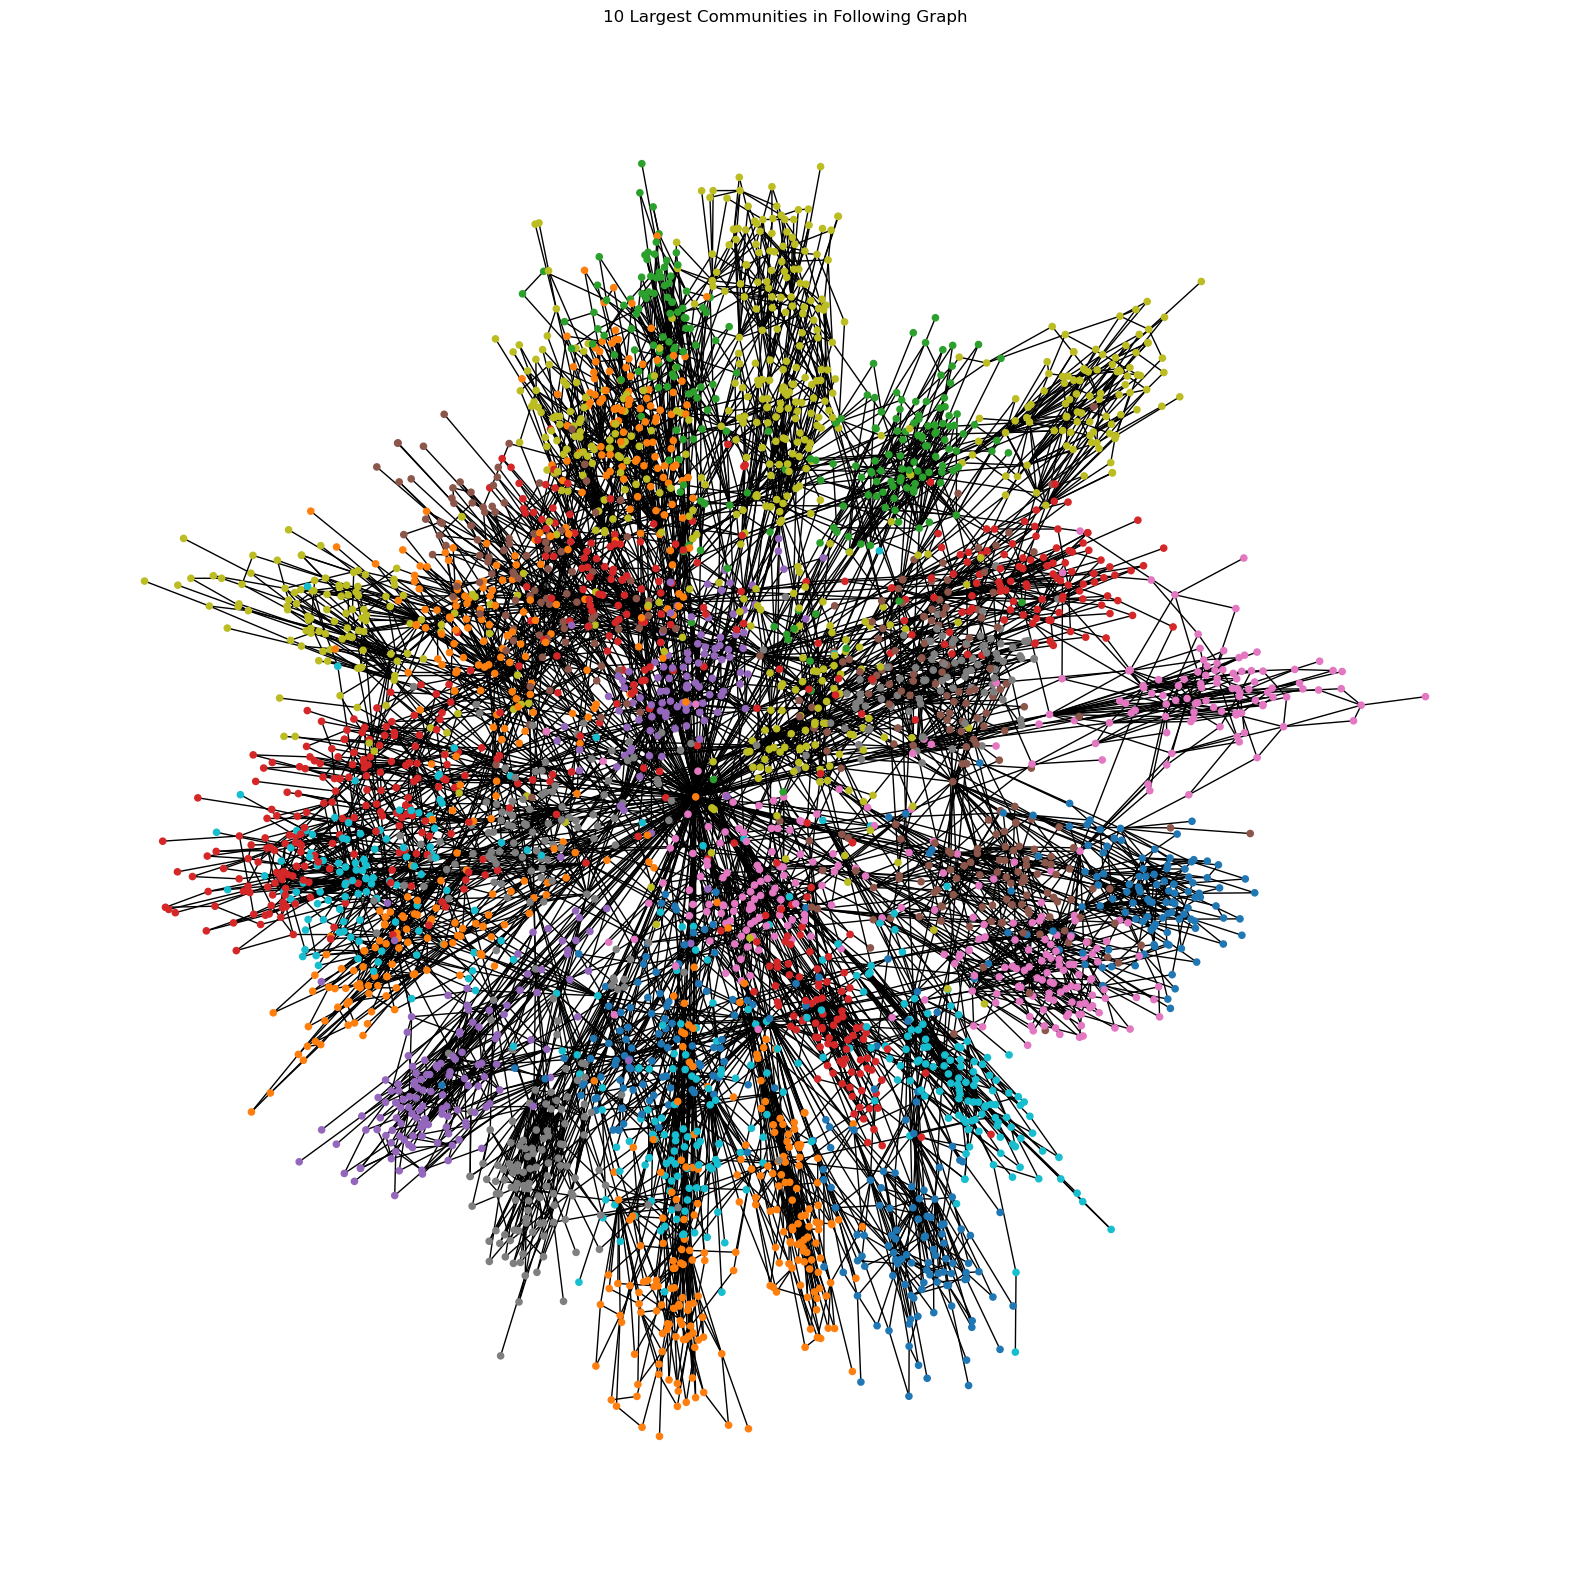

In [20]:
# Ensure that the community IDs are valid indices in partition_following
largest_communities = [comm_id for comm_id, size in sorted_communities if size > 150 and comm_id < len(partition_following)][:10]

largest_nodes = set()
for c_id in largest_communities:
    largest_nodes.update(partition_following[c_id])

largest_subgraph = following_graph.subgraph(largest_nodes)

# Create a colormap
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(largest_communities))]

# Create a dictionary to map nodes to colors based on their community
node_colors = {}
for idx, community in enumerate(largest_communities):
    for node in partition_following[community]:
        node_colors[node] = colors[idx]

# Draw the subgraph with node colors
plt.figure(figsize=(20, 20))
pos_largest = nx.fruchterman_reingold_layout(largest_subgraph)
nx.draw_networkx(largest_subgraph, pos_largest, node_color=[node_colors[node] for node in largest_subgraph.nodes()], node_size=20, with_labels=False)
plt.title("10 Largest Communities in Following Graph")
plt.axis("off")
plt.savefig('../figures/10-largest-communites-following-graph.png')
plt.show()

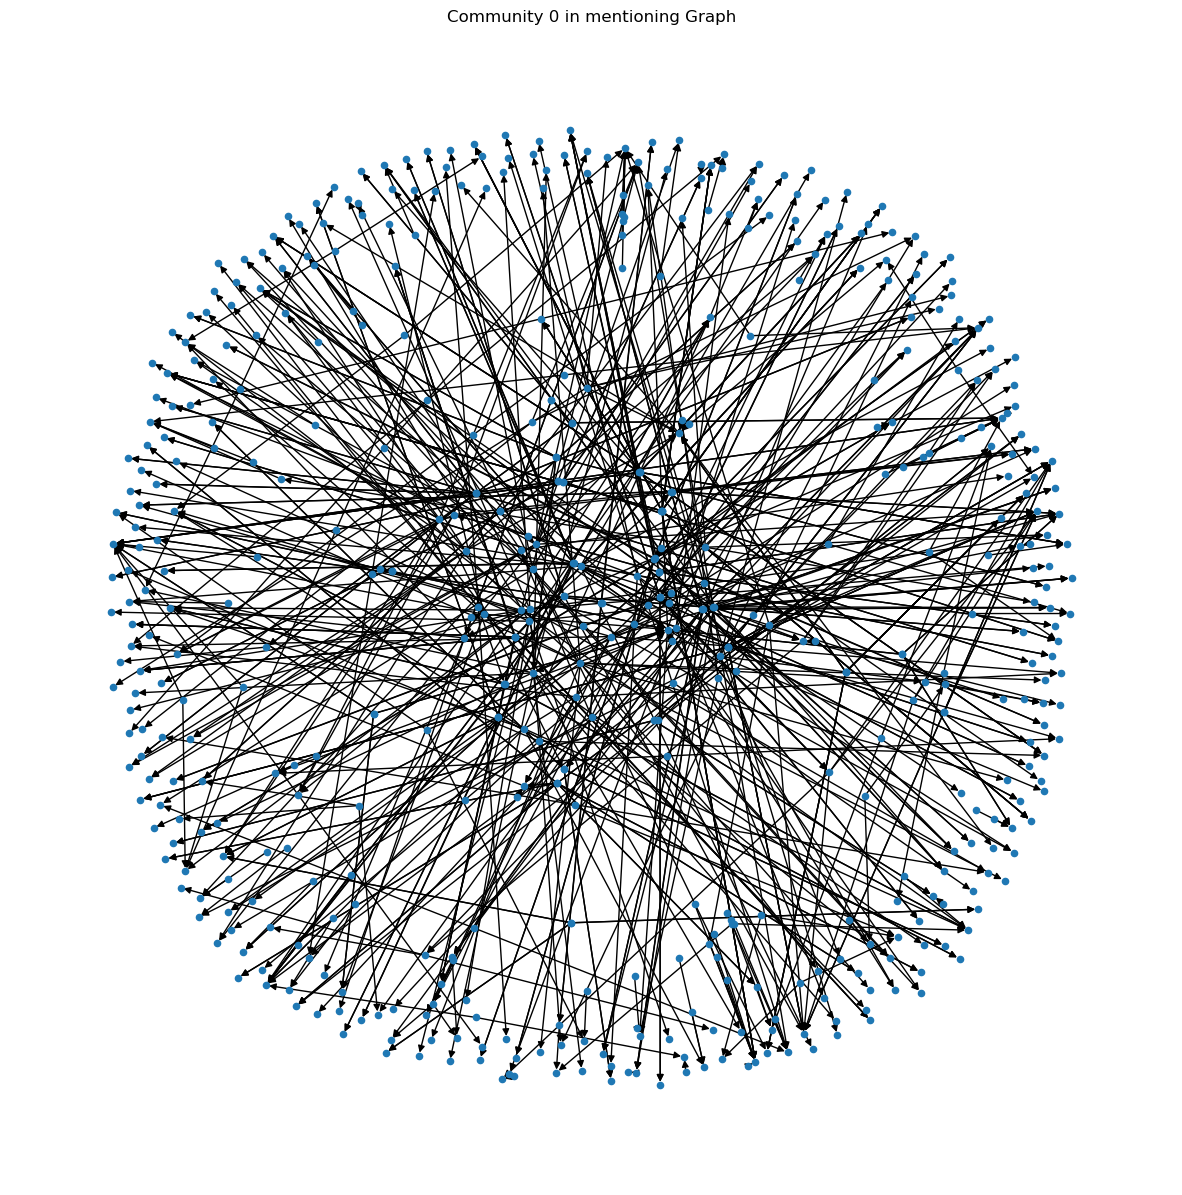

In [23]:
# Extract nodes in Community 0
community_0_nodes = partition_mention[0]

# Create a subgraph for Community 0
community_0_subgraph = mentioning_graph.subgraph(community_0_nodes)

# Draw the subgraph with a larger figure size
plt.figure(figsize=(15, 15))
pos = nx.fruchterman_reingold_layout(community_0_subgraph)
nx.draw_networkx(community_0_subgraph, pos, node_size=20, font_size=8, with_labels=False)
plt.title("Community 0 in mentioning Graph")
plt.axis("off")
plt.show()

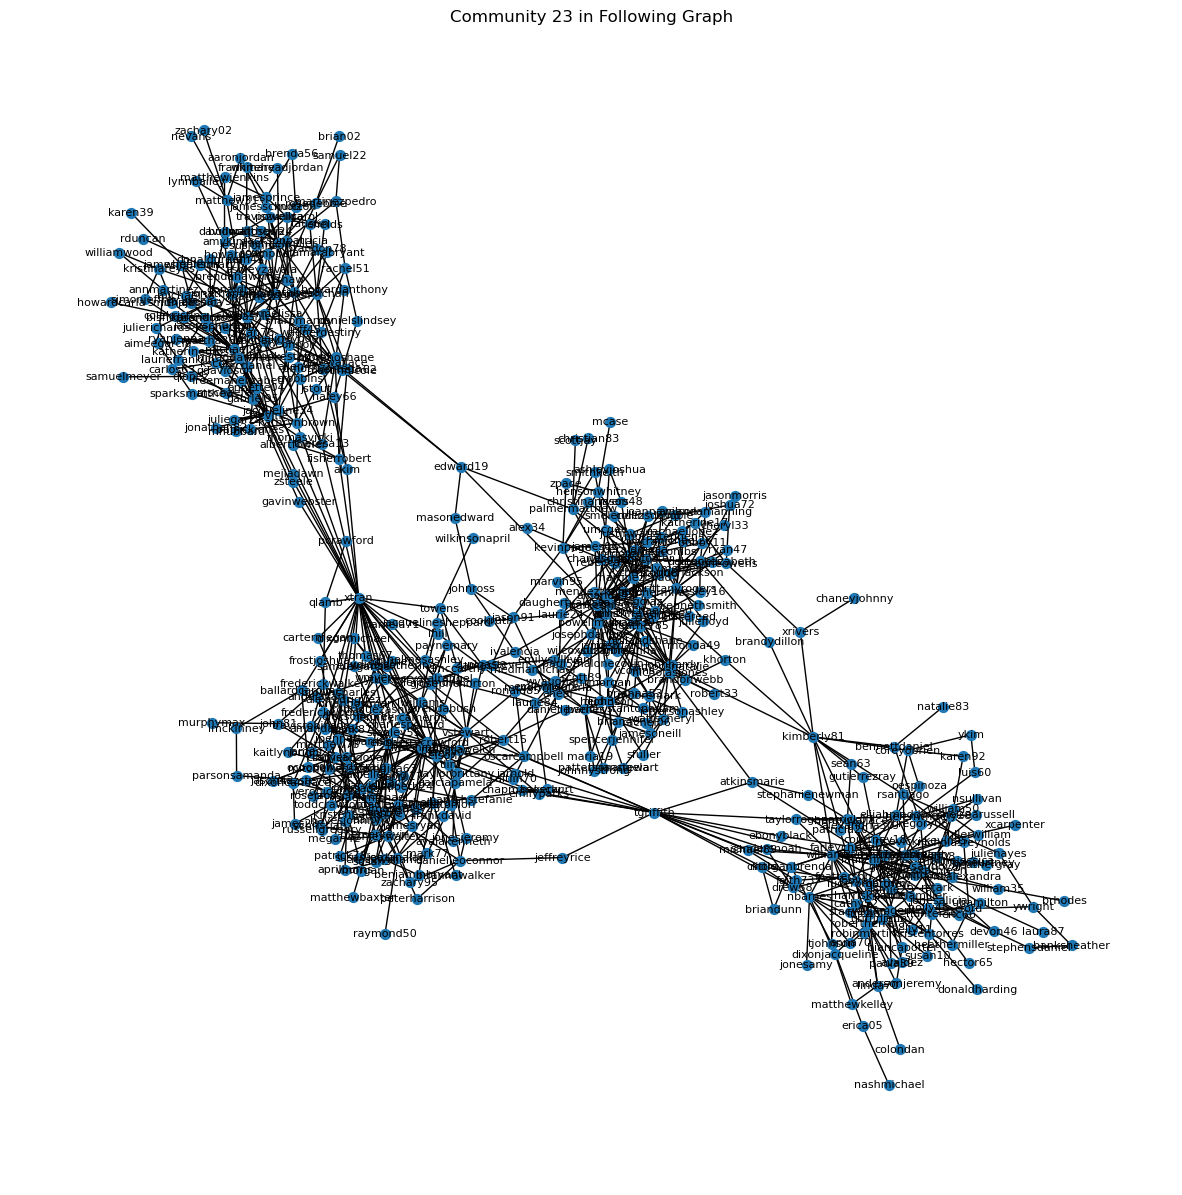

In [24]:
# Filter nodes with in-degree greater than 50
nodes_to_visualize = [node for node, in_degree in mentioning_graph.in_degree() if in_degree > 15]

# Create a subgraph with the filtered nodes
subgraph = mentioning_graph.subgraph(nodes_to_visualize)

# Generate positions for the nodes
pos = nx.spring_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(15, 15))
nx.draw_networkx(subgraph, pos, node_size=50, font_size=8, with_labels=True)
plt.title("Users Mentioned More Than 15 Times")
plt.axis("off")
plt.show()

In [25]:
# Create a dictionary to store the top users with the most followers in each community
top_users_by_community = {}

# Iterate over each community in partition_following
for community_index, community in enumerate(partition_following):
    # Filter the in-degree dictionary to include only nodes in the current community
    community_in_degree = {node: degree_centrality_following[node] for node in community if node in degree_centrality_following}
    
    # Find the user with the most followers in the current community
    if community_in_degree:
        top_user = max(community_in_degree, key=community_in_degree.get)
        top_users_by_community[community_index] = (top_user, community_in_degree[top_user])

# Print the top users with the most followers in each community
for community_index, (user, followers) in top_users_by_community.items():
    print(f"Community {community_index}: {user} with {followers} followers")

Community 0: howardnichole with 0.0010472610096670246 followers
Community 1: samantha44 with 0.0008592910848549946 followers
Community 2: matthew21 with 0.0007787325456498389 followers
Community 3: xsmith with 0.0012620837808807735 followers
Community 4: rcole with 0.0009129967776584318 followers
Community 5: kimberly49 with 0.0009935553168635876 followers
Community 6: joyce52 with 0.0007250268528464017 followers
Community 7: fsmith with 0.0013157894736842105 followers
Community 8: tlivingston with 0.0006713211600429646 followers
Community 9: bsmith with 0.0011009667024704619 followers
Community 10: esmith with 0.0010741138560687433 followers
Community 11: eortiz with 0.0008861439312567133 followers
Community 12: james14 with 0.0011278195488721805 followers
Community 13: nnash with 0.0015306122448979593 followers
Community 14: alyssa54 with 0.0010472610096670246 followers
Community 15: wsmith with 0.0021482277121374865 followers
Community 16: mary60 with 0.0014232008592910848 followers

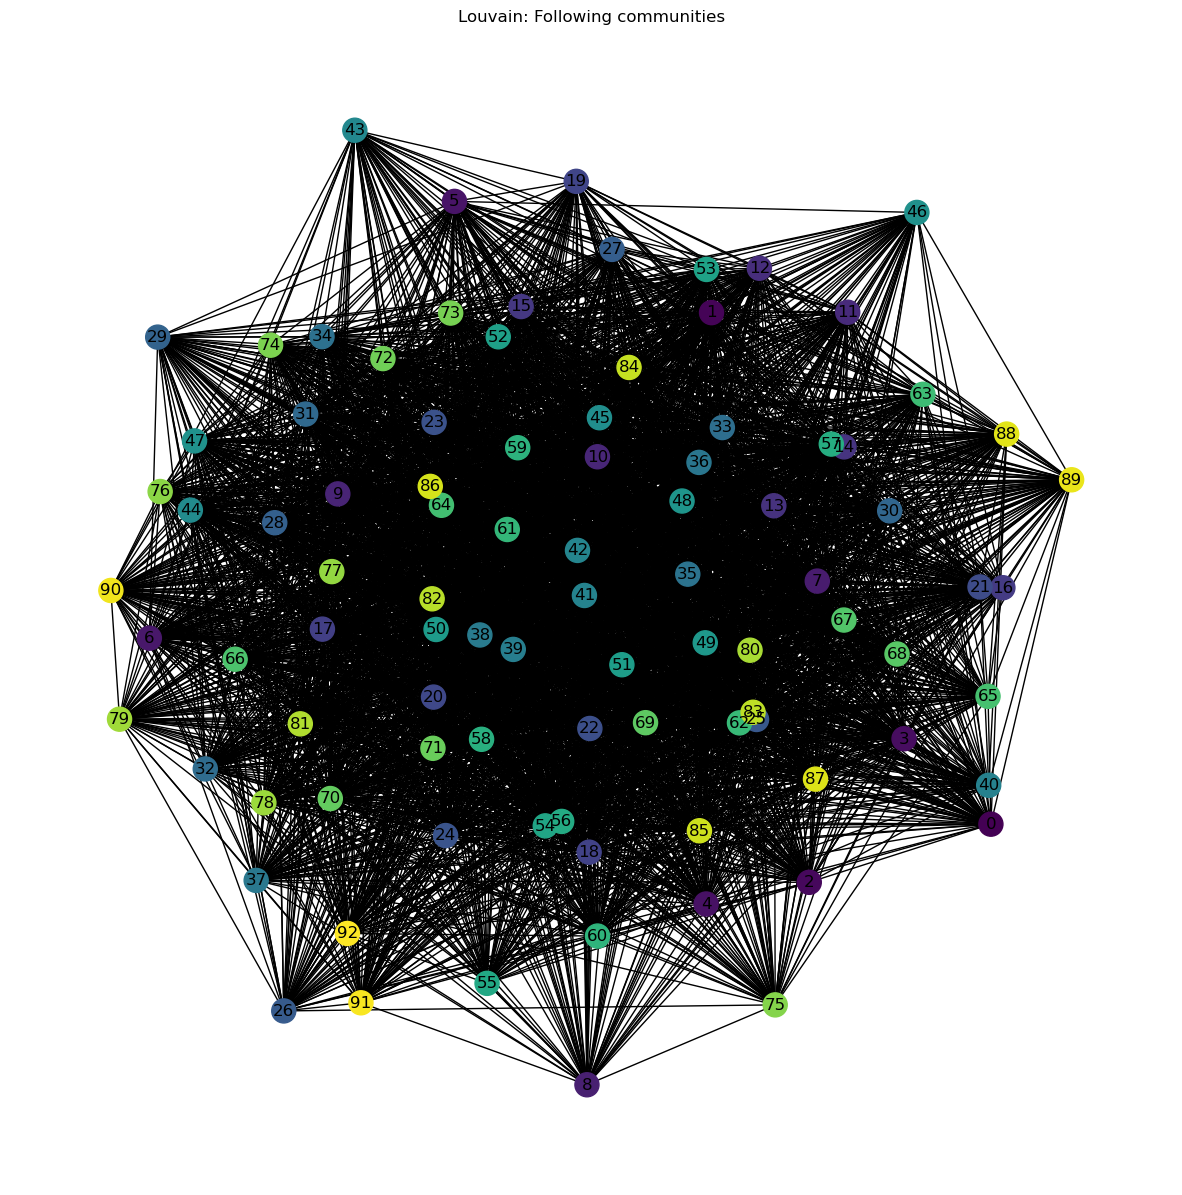

In [33]:
# Build a mapping from node to its community index
community_map = {}
for i, community in enumerate(partition_following):
    for node in community:
        community_map[node] = i

# Create a blockmodel based on the community mapping
blockmodel_graph = nx.quotient_graph(following_graph, partition_following, relabel=True)

# Plot the resulting blockmodel
plt.figure(figsize=(15, 15))
pos_block = nx.spring_layout(blockmodel_graph)
nx.draw_networkx(
    blockmodel_graph,
    pos_block,
    with_labels=True,
    node_color=range(len(blockmodel_graph))
)
plt.title("Louvain: Following communities")
plt.axis("off")
plt.savefig('../figures/mentioned-more-than-15.png')
plt.show()

In [34]:
# Compute degree centrality for the following graph (undirected)
degree_centrality_following = nx.degree_centrality(following_graph)

# Compute in-degree centrality for the mentioning graph (directed)
in_degree_centrality_mentions = nx.in_degree_centrality(mentioning_graph)

# Combine the centralities
combined_centrality = {}
for user in set(degree_centrality_following.keys()).union(in_degree_centrality_mentions.keys()):
    combined_centrality[user] = degree_centrality_following.get(user, 0) + in_degree_centrality_mentions.get(user, 0)

# Get the top 20 users by combined centrality
top_20_combined_centrality = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

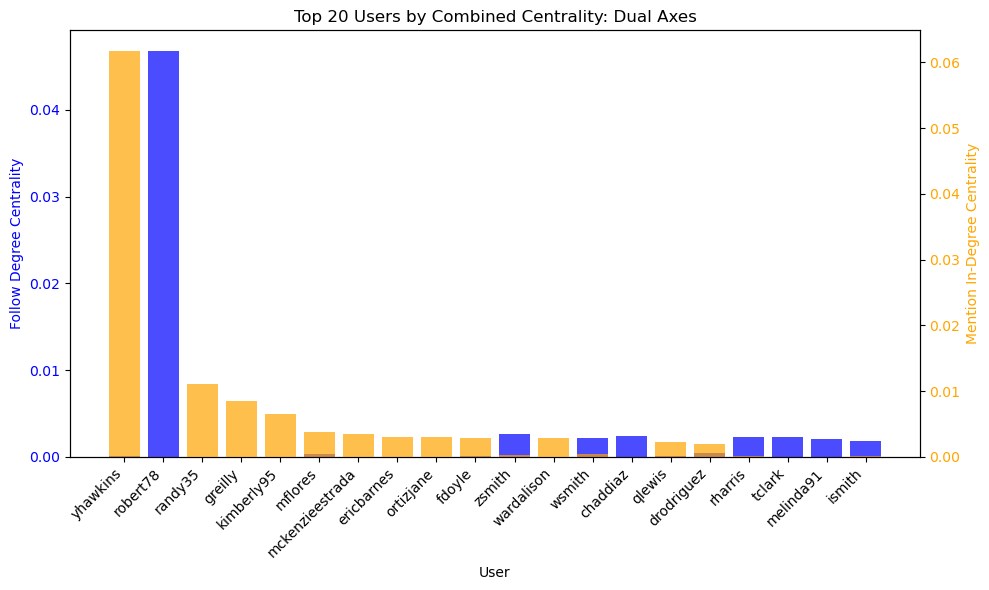

In [35]:
# Sort users based on combined centrality
users = [u for u, _ in top_20_combined_centrality]
follow_vals = [degree_centrality_following.get(u, 0) for u in users]
mention_vals = [in_degree_centrality_mentions.get(u, 0) for u in users]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot follow centrality on the first axis
ax1.bar(users, follow_vals, color='blue', alpha=0.7)
ax1.set_xlabel("User")
ax1.set_ylabel("Follow Degree Centrality", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45, ha='right')

# Plot mention centrality on the second axis
ax2 = ax1.twinx()
ax2.bar(users, mention_vals, color='orange', alpha=0.7)
ax2.set_ylabel("Mention In-Degree Centrality", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Top 20 Users by Combined Centrality: Dual Axes")
plt.tight_layout()
plt.show()